#### Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam 
from tensorflow.keras import layers

from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2D CNN Autoencoder: ####

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint
#n_samples_train = 80000
n_samples_train = 5
### Preprocessing of TRAIN Images ###
i = 0
train = []
for i in range(n_samples_train-2):
    # Change name of file to read.
    img_number = str(i+1)
    img_path = "/content/drive/MyDrive/AutoEncoder/Image_FacePoints_Train/Img_Train" + img_number + ".png"
    a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
    
    a = a[..., np.newaxis]
    train.append(a)

train = np.asarray(train)
#train = train/255.

print("-------------------- Total Images --------------------")
print("Total size TRAIN Set:", train.shape)

### Preprocessing of TEST Images ###
#n_samples_test = 15367
n_samples_test = 5
i = 0
test = []
for i in range(n_samples_test-2):
    # Change name of file to read.
    img_number = str(i+1)
    img_path = "/content/drive/MyDrive/AutoEncoder/Image_FacePoints_Test/Img_Test" + img_number + ".png"
    a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
    a = a[..., np.newaxis]
    test.append(a)

test = np.asarray(test)
test = test/255.

print("-------------------- Total Images --------------------")
print("Total size TEST Set:", test.shape)

-------------------- Total Images --------------------
Total size TRAIN Set: (3, 256, 256, 1)
-------------------- Total Images --------------------
Total size TEST Set: (3, 256, 256, 1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 30)                54494     
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 1)       92353     
                                                                 
Total params: 146,847
Trainable params: 146,399
Non-trainable params: 448
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling 

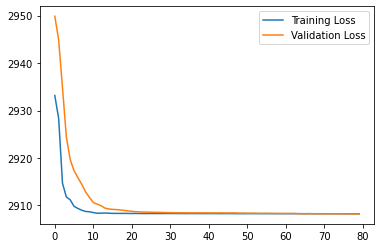

In [31]:
#2D-CNN Autoencoder (Latent Space = Flaten Vector):

# Parameters:
dropoutrate = 0.2
kernel_size = (3,3)
encoded_dim = 30

#Build Encoder.
encoder_CNN = Sequential([
Conv2D(filters = 16, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform", input_shape= (256, 256, 1)),
MaxPooling2D(4),
BatchNormalization(),
Dropout(dropoutrate),
Conv2D(filters = 32, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling2D(4),
BatchNormalization(),
Dropout(dropoutrate),
Conv2D(filters = 64, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling2D(4),
BatchNormalization(),
Dropout(dropoutrate),
Flatten(),
Dense(encoded_dim, activation='leaky_relu', kernel_initializer = "he_uniform"),
])

#Build Decoder.
decoder_CNN = Sequential ([
Dense(1024, activation='relu', kernel_initializer = "he_uniform", input_shape=(encoded_dim,)),
Reshape((4,4,64)),
Conv2DTranspose(filters = 64, kernel_size = kernel_size, padding='same', activation='leaky_relu', kernel_initializer = "he_uniform"),
UpSampling2D(4),
BatchNormalization(),
Conv2DTranspose(filters = 32, kernel_size = kernel_size, padding='same', activation='leaky_relu', kernel_initializer = "he_uniform"),
UpSampling2D(4),
BatchNormalization(),
Conv2DTranspose(filters = 16, kernel_size = kernel_size, padding='same', activation='leaky_relu', kernel_initializer = "he_uniform"),
UpSampling2D(4),
BatchNormalization(),
Conv2DTranspose(filters=1, kernel_size = kernel_size, padding="same", activation = "sigmoid", kernel_initializer = "he_uniform")
])

#Merge models to Autoencoder.
input = Input(shape=(train.shape[1], train.shape[2], train.shape[3]))
output = encoder_CNN(input)
output = decoder_CNN(output)
conv_autoencoder_CNN = Model(inputs = input, outputs = output)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
conv_autoencoder_CNN.compile(optimizer=nadam, loss='mse')
conv_autoencoder_CNN.summary()
conv_autoencoder_CNN.layers[1].summary()
conv_autoencoder_CNN.layers[2].summary()

history = conv_autoencoder_CNN.fit(train, train, batch_size=128, epochs=80, validation_split=0.2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
conv_autoencoder_CNN.save('/content/drive/MyDrive/Models/conv_autoencoder_CNN.h5')
decoder_CNN.save('/content/drive/MyDrive/Models/decoder_CNN.h5')
encoder_CNN.save('/content/drive/MyDrive/Models/encoder_CNN.h5')

In [ ]:
encoder_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Models/encoder_CNN.h5')
decoder_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Models/decoder_CNN.h5')

In [27]:
#Calculate Test dataset RMSE - Conv Autoencoder (Latent Space = Vector)
test_pred = conv_autoencoder_CNN.predict(test)
#test_pred = test_pred.transpose(0,2,1)
#test = test.transpose(0,2,1)
print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0)).mean()
print("Test MAE: ", test_mae_loss)

-------------------- Test Evaluation Results--------------------
Test MAE:  0.32339645599431815


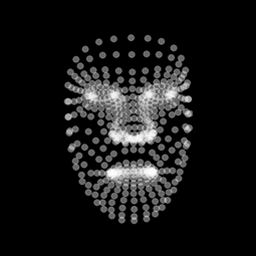

In [32]:
img = test[1]*255.
img = img.astype(int)
img = img[:, :, 0]
cv2_imshow(img)

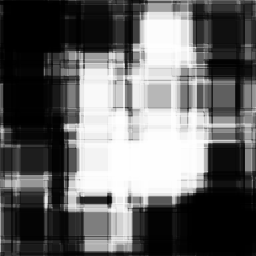

In [33]:
img = test_pred[1]*255.
img = img.astype(int)
img = img[:, :, 0]
cv2_imshow(img)